In [1]:
import tensorflow as tf
from model import LanguageModel
import json
import numpy as np
import re
import pandas as pd
import unicodedata
import numpy as np
import scipy
import seaborn as sns
%matplotlib inline

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
with open('baomoi_punc/word2idx.json', 'r') as inp:
    word2idx = json.load(inp)
with open('baomoi_punc/char2idx.json', 'r') as inp:
    char2idx = json.load(inp)
idx2word = {k: v for v, k in word2idx.items()}
idx2char = {k: v for v, k in char2idx.items()}

In [4]:
params = {
   "rnn_layers":[
      {
         "units": 1024,
         "input_size": 1024,
         "drop_i": 0.01,
         "wdrop": 0.05,
         "drop_o": 0.01
      },
      {
         "units": 1024,
         "input_size": 1024,
         "wdrop": 0.05,
         "drop_o": 0.01
      },
      {
         "units": 1024,
         "input_size": 1024,
         "drop_o": 0.1,
         "wdrop": 0.05
      }
   ],
   "vocab_size": len(word2idx) + 1,
   "drop_e": 0.0,
   "char_vocab_size": len(char2idx) + 1,
   "char_cnn_layers": [
        [1, 16],
        [2, 16],
        [3, 32],
        [4, 64],
        [5, 128],
        [6, 256],
        [7, 512]
    ],
    "char_vec_size": 16,
}

In [5]:
model = LanguageModel(**params, is_training=False, is_encoding=True)

In [6]:
model.build_model()
saver = tf.train.Saver([x for x in tf.global_variables() if x not in tf.get_collection('LSTM_SAVED_STATE')])
sess.run(tf.global_variables_initializer())
saver.restore(sess, 'test/model.cpkt-200436')

INFO:tensorflow:Restoring parameters from test/model.cpkt-200436


In [7]:
def clean_text(x):
    return re.sub('\d+','N',re.sub('[ ]+',' ',re.sub('[\n\r]+','\n', str(unicodedata.normalize('NFKC', x.lower())))))

In [8]:
def pad_sequence(words):
    maxlen = max(len(x) for x in words)
    arr = np.zeros(shape=(len(words), 1, maxlen))
    for ir in range(len(arr)):
        s = words[ir]
        arr[ir][0][:len(s)] = s
    return arr

In [43]:
def __embed_sequence(sentence):
#     print(sentence)
    unk_char_idx = char2idx['U']
    sentence = [[char2idx.get(x, unk_char_idx) for x in word] for word in sentence]
#     print(sentence)
#     print(' '.join(''.join(idx2char[c] for c in w) for w in sentence))
    seq_len = len(sentence)
    inputs = pad_sequence(sentence)
#     print(inputs)
    embeddings = sess.run(model.layerwise_max[-1], feed_dict={
        model.inputs: inputs, model.seq_lens: [seq_len], model.reset_state: True
    })
    return embeddings
def embed_sentence(sentence):
    sentence = clean_text(sentence)
    sentence = [re.sub('\W+', '', x) for x in sentence.split()]
    return __embed_sequence(sentence)

In [44]:
def word_importance(sentence):
    tokens = clean_text(sentence)
    tokens = [re.sub('\W+', '', x) for x in tokens.split()]
    full_embed = __embed_sequence(tokens)
    word_omit_embed = [
        __embed_sequence(tokens[:i] + tokens[i+1:]) for i in range(len(tokens))
    ]
    return pd.DataFrame(data={'tokens': ['{} {}'.format(i, x) for i, x in enumerate(tokens)], 'importance': [scipy.spatial.distance.cosine(full_embed, x) for x in word_omit_embed]})

In [45]:
sns.set(rc={'figure.figsize':(8, 8)})

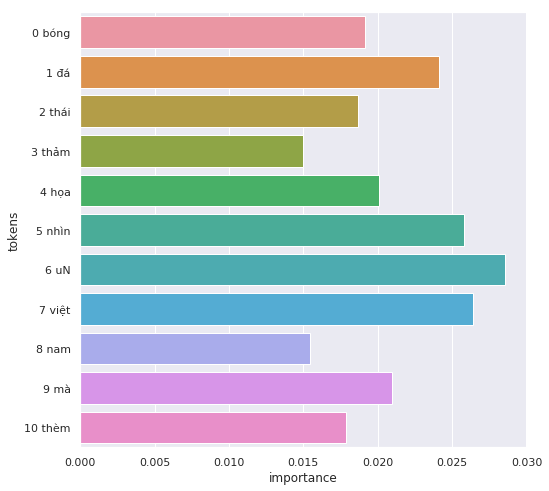

In [46]:
sns.barplot(y='tokens', x='importance', data=word_importance('Bóng đá Thái thảm họa: Nhìn U23 Việt Nam mà thèm'))

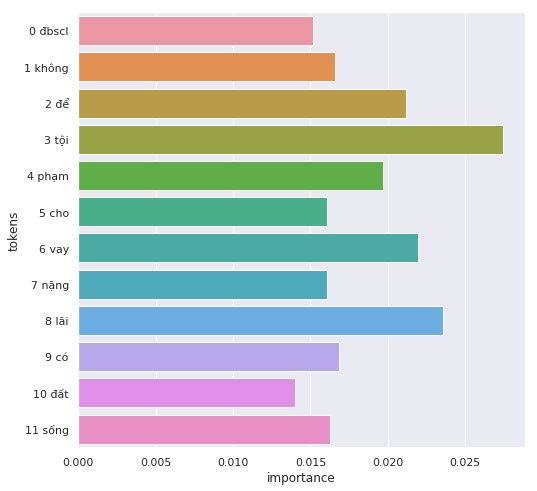

In [47]:
sns.barplot(y='tokens', x='importance', data=word_importance('ĐBSCL: Không để tội phạm cho vay nặng lãi có đất sống'))

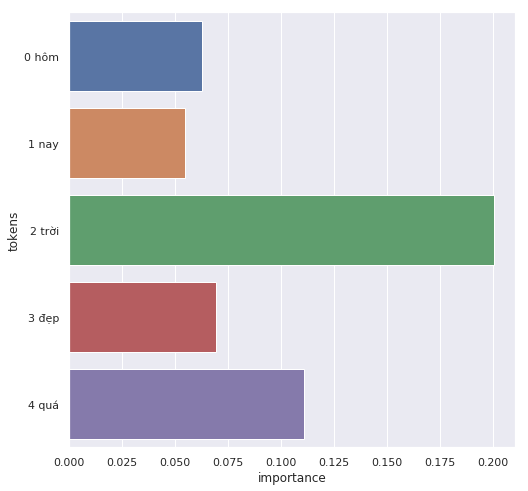

In [48]:
sns.barplot(y='tokens', x='importance', data=word_importance('hôm nay trời đẹp quá'))

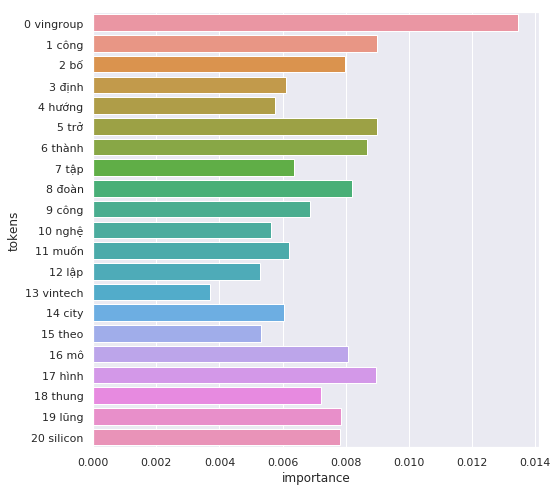

In [49]:
sns.barplot(y='tokens', x='importance', data=word_importance('Vingroup công bố định hướng trở thành tập đoàn công nghệ, muốn lập VinTech City theo mô hình thung lũng Silicon'))

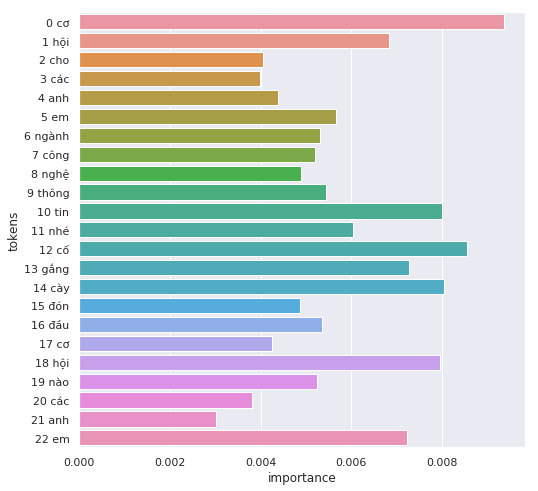

In [50]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Cơ hội cho các anh em ngành Công Nghệ Thông Tin nhé, cố gắng cày đón đầu cơ hội nào các anh em'))

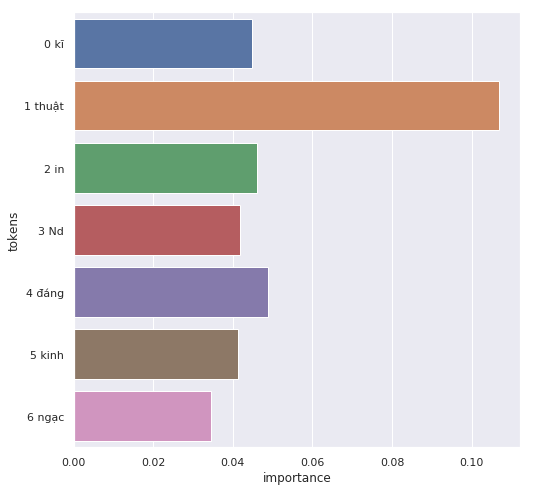

In [51]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Kĩ thuật in 3D đáng kinh ngạc.'))

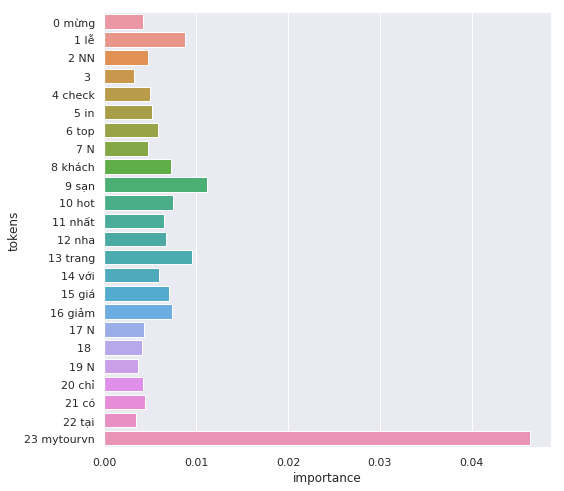

In [52]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('MỪNG LỄ 2/9 - CHECK IN TOP 5 KHÁCH SẠN HOT NHẤT NHA TRANG VỚI GIÁ GIẢM 50% + 10% CHỈ CÓ TẠI MYTOUR.VN'))

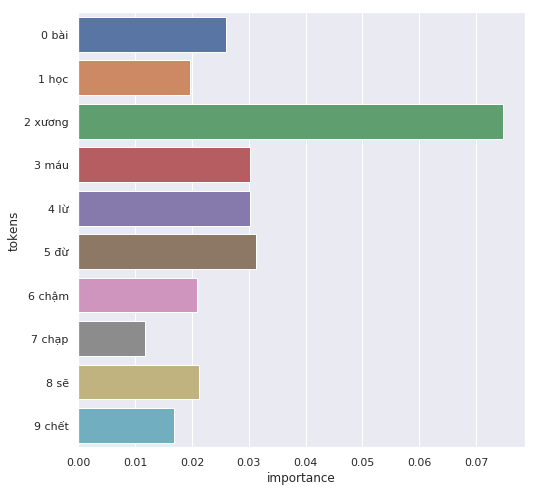

In [53]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Bài học xương máu. Lừ đừ chậm chạp sẽ chết'))

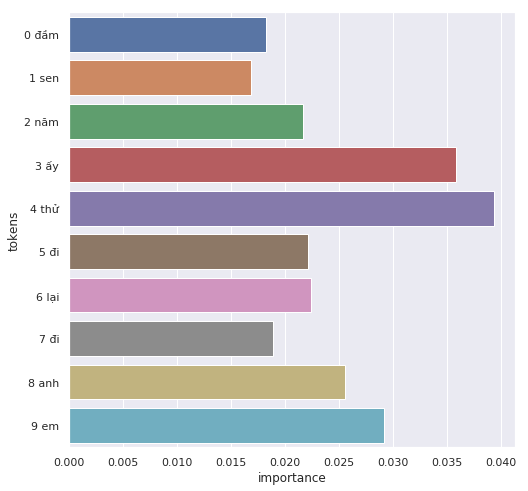

In [54]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Đầm Sen năm ấy... Thử đi lại đi anh em.'))

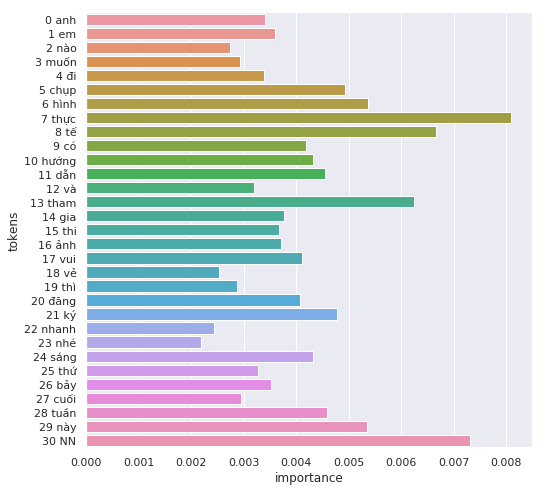

In [55]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Anh em nào muốn đi chụp hình thực tế có hướng dẫn và tham gia thi ảnh vui vẻ, thì đăng ký nhanh nhé. Sáng Thứ Bảy cuối tuần này 25/8'))

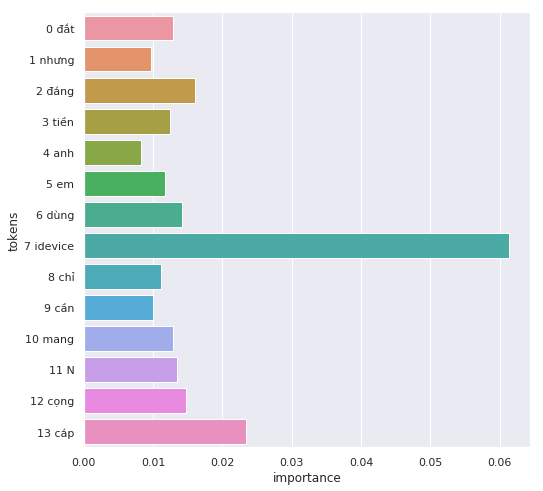

In [56]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Đắt nhưng đáng tiền. Anh em dùng iDevice chỉ cần mang 1 cọng cáp.'))

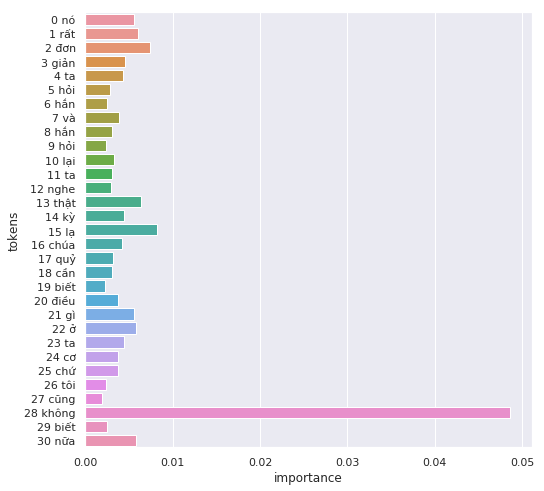

In [57]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Nó rất đơn giản; ta hỏi hắn và hắn hỏi lại ta. Nghe thật kỳ lạ. Chúa quỷ cần biết điều gì ở ta cơ chứ? Tôi cũng không biết nữa.'))

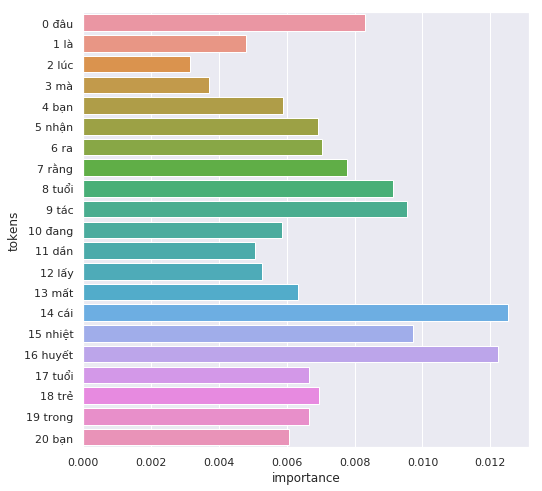

In [58]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance('Đâu là lúc mà bạn nhận ra rằng tuổi tác đang dần lấy mất cái nhiệt huyết tuổi trẻ trong bạn?'))

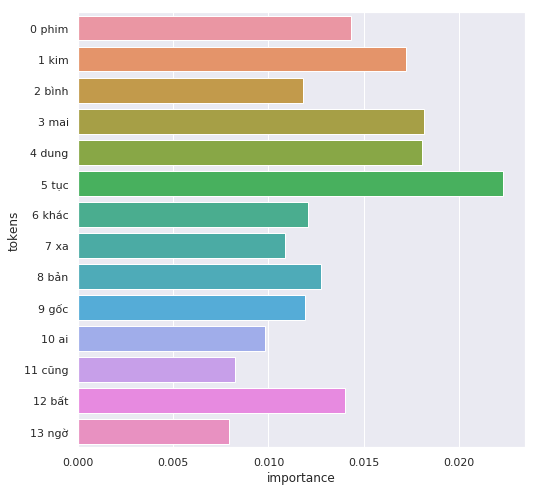

In [59]:
sns.barplot(y='tokens', x='importance', 
            data=word_importance(
                'Phim "Kim Bình Mai" dung tục khác xa bản gốc ai cũng bất ngờ'
            ))